In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase.io import read
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import glob
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [34]:
## Set up the plotting environment
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [ ]:
## Set the plotting parameters
seed = 0
identifier = ""
prefix = "DRatios/DALL_TMP/"
method = "_v1_r0_w0_g0_m0"

In [36]:
## Set the descriptors
from agox.models.descriptors import SOAP
local_descriptor = local_descriptor = SOAP.from_species(["Al"], r_cut=5.0)

In [37]:
## Set the calculators
from chgnet.model import CHGNetCalculator
from ase.calculators.singlepoint import SinglePointCalculator
calc = CHGNetCalculator()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [ ]:
## Load known structures
poscar_files = glob.glob("../known_phases/*.vasp")
known_phases = []
opacity_list = []
known_phase_labels = []
for poscar_file in poscar_files:
  phase = read(poscar_file)
  opacity = None
  if "mp-134.vasp" in poscar_file:
    print("FCC")
    cell = phase.get_cell()
    cell = [ vec * 4.02 / np.linalg.norm(vec) for vec in cell]
    phase.set_cell(cell, scale_atoms=True)
    opacity = 1.0
    label = "FCC (mp-134)"
  elif "mp-2647008.vasp" in poscar_file:
    print("HCP")
    cell = phase.get_cell()
    cell = [ vec * 3.56 / np.linalg.norm(vec) for vec in cell]
    phase.set_cell(cell, scale_atoms=True)
    opacity = 0.6
    label = "HCP (mp-2647008)"
  elif "mp-998860.vasp" in poscar_file:
    print("BCC")
    cell = phase.get_cell()
    cell = [ vec * 3.10 / np.linalg.norm(vec) for vec in cell]
    phase.set_cell(cell, scale_atoms=True)
    opacity = 0.4
    label = "BCC (mp-998860)"
  elif "mp-1183144.vasp" in poscar_file:
    print("$\\alpha$")
    cell = phase.get_cell()
    # cell[0] = [ vec * 4.94 / np.linalg.norm(vec) for vec in cell]
    # cell[1] = [ vec * 4.94 / np.linalg.norm(vec) for vec in cell]
    cell[2] = cell[2] * 9.88 / np.linalg.norm(cell[2])
    phase.set_cell(cell, scale_atoms=True)
    opacity = 0.7
    label = "$\\alpha$ (mp-1183144)"
  else:
    print("Skipping ", poscar_file)
    continue
  opacity_list.append(opacity)
  known_phase_labels.append(label)
  phase.calc = calc
  known_phases.append(phase)

BCC
$\alpha$
FCC
HCP


In [ ]:
## Load the unrelaxed structures
unrlxd_structures = read(prefix+"DOutput"+method+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures:
  structure.calc = calc
  

In [ ]:
## Load the relaxed structures
rlxd_structures = read(prefix+"DOutput"+method+"/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures:
  structure.calc = calc

In [ ]:
## Read energies from energies_unrlxd_seed0.txt and add to the respective structures using a SinglePointCalculator
## The file has the form "index energy"
## This is done because there seem to be issues with storing the energy in the ASE trajectory file for some setups
filename = prefix+"DOutput"+method+"/energies_unrlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        unrlxd_structures[index].calc = SinglePointCalculator(unrlxd_structures[index], energy=energy * len(unrlxd_structures[index]))


filename = prefix+"DOutput"+method+"/energies_rlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        rlxd_structures[index].calc = SinglePointCalculator(rlxd_structures[index], energy=energy * len(rlxd_structures[index]))

In [42]:
## Get the minimum energy
min_energy = np.min([structure.get_potential_energy()/len(structure) for structure in rlxd_structures])

In [43]:
## Calculate energies per atom for each unrelaxed structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unrlxd_structures]
unrlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Unrelaxed min energy: ", np.min(energies_per_atom))

Unrelaxed min energy:  -3.661088705062866


In [44]:
## Calculate energies per atom for each relaxed structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in rlxd_structures]
rlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Relaxed min energy: ", np.min(energies_per_atom))

Relaxed min energy:  -3.663501501083374


In [45]:
## Set up the PCA
pca = PCA(n_components=2)

In [46]:
## Get the 'super atom' descriptors for the unrelaxed structures
unrlxd_super_atoms = []
for structure in unrlxd_structures:
  unrlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [47]:
## Get the 'super atom' descriptors for the relaxed structures
rlxd_super_atoms = []
for structure in rlxd_structures:
  rlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [48]:
## Get the 'super atom' descriptors for the known structures
known_super_atoms = []
for structure in known_phases:
  known_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [49]:
## Fit the PCA model to the unrelaxed or relaxed structures
rlxd_string = "rlxd"

In [50]:
## Save pca model
import pickle
if False:
  pca.fit(np.squeeze([arr for arr in rlxd_super_atoms]))
  with open("pca_model_all_rlxd_r_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

## Load pca model
with open("pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [51]:
## Transform the unrelaxed and relaxed structures to the reduced space
unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in unrlxd_super_atoms]))
rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in rlxd_super_atoms]))
known_X_reduced = pca.transform(np.squeeze([arr for arr in known_super_atoms]))

In [87]:
## Get the index of the structure with the minimum energy
min_energy_index = np.argmin(rlxd_delta_en_per_atom)
print(min_energy_index)


1031


In [113]:
tol_x = 3  # Adjust as needed
tol_y = 0.2
clusters = []         # will store the current "center" of each cluster (basin)
cluster_indices = []  # list of lists: each sublist stores indices belonging to that cluster

for i, pt in enumerate(rlxd_X_reduced):
    assigned = False
    for j, center in enumerate(clusters):
        if all( abs(pt - center) < [tol_x, tol_y] ):
            # Add index to this cluster and update the cluster center (mean of points)
            cluster_indices[j].append(i)
            clusters[j] = np.mean(rlxd_X_reduced[cluster_indices[j]], axis=0)
            assigned = True
            break
        # if np.linalg.norm(pt - center) < tol:
        #     # Add index to this cluster and update the cluster center (mean of points)
        #     cluster_indices[j].append(i)
        #     clusters[j] = np.mean(rlxd_X_reduced[cluster_indices[j]], axis=0)
        #     assigned = True
        #     break
    if not assigned:
        # Start a new cluster
        clusters.append(pt.copy())
        cluster_indices.append([i])

print(len(cluster_indices))
for i in range(len(cluster_indices)):
    print(cluster_indices[i])


26
[0, 1, 2, 3, 4, 60, 61, 62, 63, 64, 120, 121, 122, 123, 124, 180, 181, 182, 183, 184, 240, 241, 242, 243, 244, 300, 301, 302, 303, 304, 360, 361, 362, 363, 364, 420, 421, 422, 423, 424, 480, 481, 482, 483, 484, 540, 541, 542, 543, 544, 600, 601, 602, 603, 604, 660, 661, 662, 663, 664, 720, 721, 722, 723, 724, 780, 781, 782, 783, 784, 840, 841, 842, 843, 844, 900, 901, 902, 903, 904, 960, 961, 962, 963, 964, 1020, 1021, 1022, 1023, 1024, 1080, 1081, 1082, 1083, 1084, 1140, 1141, 1142, 1143, 1144]
[5, 6, 7, 8, 9, 65, 66, 67, 68, 69, 125, 126, 128, 129, 185, 187, 188, 189, 245, 246, 247, 248, 305, 306, 307, 365, 366, 367, 368, 369, 425, 426, 427, 429, 485, 488, 489, 545, 546, 548, 549, 605, 606, 608, 665, 666, 667, 668, 669, 725, 726, 728, 729, 785, 786, 787, 788, 845, 846, 847, 848, 849, 905, 906, 907, 908, 909, 965, 966, 968, 969, 1025, 1026, 1027, 1028, 1085, 1087, 1088, 1089, 1145, 1148, 1149]
[10, 11, 12, 13, 14, 70, 71, 72, 73, 74, 130, 132, 133, 134, 190, 191, 192, 193, 194, 251

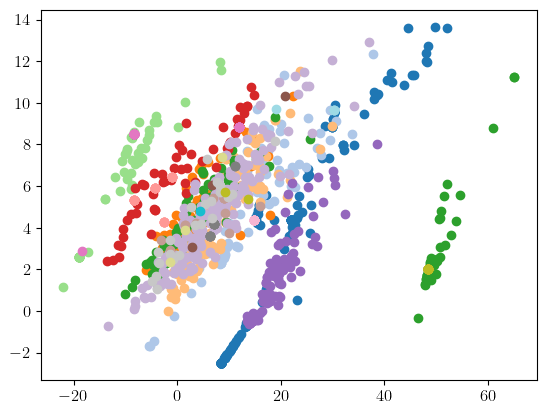

In [114]:
from matplotlib import cm

n_clusters = len(clusters)
colors = cm.tab20(np.linspace(0, 1, n_clusters))
for idx, indices in enumerate(cluster_indices):
    plt.scatter(unrlxd_X_reduced[indices, 0],unrlxd_X_reduced[indices, 1], color=colors[idx])

[1.0, 0.6, 0.6, 0.4]
[1.0, 0.4, 0.4, 0.6]
[1.0, 0.30000000000000004, 0.30000000000000004, 0.7]
[1.0, 0.0, 0.0, 1.0]
[1.0, 0.6, 0.6, 0.4]
[1.0, 0.4, 0.4, 0.6]
[1.0, 0.30000000000000004, 0.30000000000000004, 0.7]
[1.0, 0.0, 0.0, 1.0]


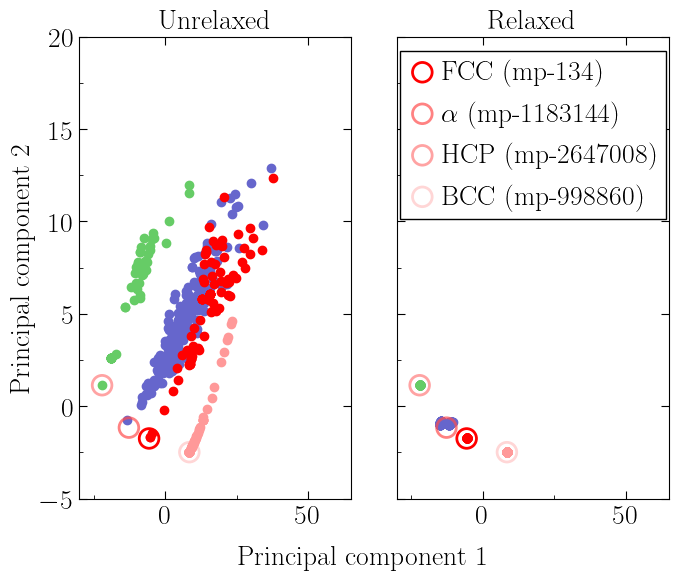

In [ ]:
## Plot the PCA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

## Get the maximum energy for the colourbar
#max_en = min(3.0, max(np.max(unrlxd_delta_en_per_atom), np.max(rlxd_delta_en_per_atom)))

## Plot the PCA
colorlist = [
    (0.4, 0.4, 0.8, 1.0),
    (0.4, 0.8, 0.4, 1.0),
    (1.0, 0.0, 0.0, 1.0),
    (1.0, 0.6, 0.6, 1.0),
    ]
i = -1
for idx, indices in reversed(list(enumerate(cluster_indices))):
    # if idx in [ 0, 2, 4, 6]:
    # if idx in [ 0, 1, 4, 6]:
     if idx in [ 0, 2, 7, 12]: # [tol_x = 3, tol_y = 0.2]
        i += 1
        #plt.scatter(unrlxd_X_reduced[indices, 0],unrlxd_X_reduced[indices, 1], color=colors[idx])
        axes[0].scatter(unrlxd_X_reduced[indices, 0], unrlxd_X_reduced[indices, 1], color=colorlist[i])
        axes[1].scatter(rlxd_X_reduced[indices, 0], rlxd_X_reduced[indices, 1], color=colorlist[i])

#axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=unrlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
#axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=rlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)


# Sort pairs of opacity and X_reduced by opacity value (highest to lowest)
sorted_pairs = sorted(zip(opacity_list, known_X_reduced, known_phase_labels), key=lambda x: x[0], reverse=False)
## Add the minimum energy structures to the plot
for ax in axes:
    for i, X in enumerate(sorted_pairs):
        print([1.0, 1.0-X[0], 1.0-X[0], X[0]])
        ax.scatter(X[1][0], X[1][1], s=200, edgecolor=[1.0, 1.0-X[0], 1.0-X[0], X[0]], facecolor='none', linewidth=2, label=X[2])
    if ax == axes[1]:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1.0, edgecolor='black', fancybox=False, bbox_to_anchor=(1.041, 1.0), fontsize=20, handletextpad=0.2, borderpad=0.3, handlelength=1)
  


## Add labels
fig.text(0.5, 0.0, 'Principal component 1', ha='center', fontsize=20)
axes[0].set_ylabel('Principal component 2', fontsize=20)
axes[0].set_title('Unrelaxed', fontsize=20)
axes[1].set_title('Relaxed', fontsize=20)
if rlxd_string == "rlxd":
  xlims = [-30, 65]
  ylims = [-5, 20]
else:
  xlims = [-42, 55]
  ylims = [-12, 30]

for ax in axes:
    ax.tick_params(axis='both', direction='in', length=6, labelsize=20)
    # ax.yaxis.set_major_locator(MultipleLocator(3))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='minor', length=3, direction='in')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

## Unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]

axes[1].set_xticks(xticks)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

## Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

## Add colorbar next to the axes
#cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
#cbar.set_label('Formation energy (eV/atom)', fontsize=15)

## Save the figure
plt.savefig('Al_RAFFLE_pca_'+rlxd_string+'_fit_seed'+str(seed)+'_boa'+method+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')


In [58]:
## Identify the line of structures in the lower right corner
for i in range(len(rlxd_X_reduced)):
  if rlxd_X_reduced[i, 0] > 40 and rlxd_X_reduced[i, 0] < 45 and rlxd_X_reduced[i, 1] > -5 and rlxd_X_reduced[i, 1] < 0:
    print(i)

In [60]:
view(rlxd_structures[138])
print(rlxd_X_reduced[138])

[-5.29144493  2.06021608]


In [68]:
view(rlxd_structures[30])
print(rlxd_X_reduced[30])

[46.21698951 -0.52926592]


In [67]:
view(unrlxd_structures[1174])
print(unrlxd_X_reduced[1174])

[48.50032929  2.03884429]
